### Nucleosome score and positioning

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.multitest import fdrcorrection as fdr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from multiprocessing import Pool
from functools import partial
import itertools
%matplotlib inline  

In [2]:
# calculate nucleosome score
def calculate_nucleosome_score (genome,Dict_sample,Sample):
    
     
    #load MNAse info 
    data=pd.read_csv(Dict_sample[Sample],sep='\t',names=['chr','start','end']) 


    #remove duplicates and filter reads
    data=(data.drop_duplicates()
          .query('end-start >= 75 and end-start <= 150 and start > 0 and end > 0')
          .reset_index(drop=True))

    #rename Scaffold
    data['scaffold']=data.scaffold.str.split('_').str[1]

    #convert scaffold, start and end into integers
    data[['scaffold','start','end']]=data[['scaffold','start','end']].astype(int)
    
    # select the 75bp in the middle
    data['center']=round((data.end+data.start)/2,0)
    data['start']=data['center']-37
    data['end']=data['center']+38
    data[['scaffold','start','end']]=data[['scaffold','start','end']].astype(int)
    
    #add reads 
    for i in range(data.shape[0]):
        genome[data.scaffold.iloc[i]][(data.start.iloc[i]):(data.end.iloc[i])]+=1

    # calculate density distrbution
    total=sum(np.array([sum(genome[i])for i in genome.keys()]))/(10**6)

    for i in genome.keys():
        genome[i] = genome[i]/total
        
    np.save('/Users/sgnan/Desktop/paramecium/tracks/'+Sample+'_nucleosome_score.npy', genome) 
        
    return(0)

In [3]:
#load scaffold 
scaffold=pd.read_csv('/Volumes/Storage3/Paramecium.FromChunlong/Data/Genome/mac_51/20111128.Scaffold.tab',sep='\t')
scaffold[['Base','scaffold']]=scaffold.Scaffold.str.split('_', expand=True)
scaffold=scaffold.filter(['scaffold','Length']).astype(int).sort_values(['scaffold']).reset_index(drop=True)

In [4]:
#create a dictionary to store the data
genome_dictionary={scaffold.scaffold.iloc[i]:np.array([0]*scaffold.Length.iloc[i]) for i in range(len(scaffold.Length))}

In [5]:
#dictionary sample
samples={
    'D1':'/Volumes/Storage3/Paramecium.FromChunlong/nucleosome_data/PTET_NakedDNA_D1_ACAGTG.BOWTIE.pt_51.pe.sorted_filtered_sorted_name_fixedmate.bed',
    'D2':'/Volumes/Storage3/Paramecium.FromChunlong/nucleosome_data/PTET_NakedDNA_D2_GCCAAT.BOWTIE.pt_51.pe.sorted_filtered_sorted_name_fixedmate.bed',
    'S32new':'/Volumes/Storage3/Paramecium.FromChunlong/nucleosome_data/PTET_MonoNuc_3-2new_CTTGTA.BOWTIE.pt_51.pe.sorted_filtered_sorted_name_fixedmate.bed',
    'S41':'/Volumes/Storage3/Paramecium.FromChunlong/nucleosome_data/PTET_MonoNuc_4-1_GATCAG.BOWTIE.pt_51.pe.sorted_filtered_sorted_name_fixedmate.bed'
        }

#parallelize: run only the first time

p = Pool(4)

p.map(partial(calculate_nucleosome_score,genome_dictionary,samples),samples.keys())

p.close()

p.join()


In [6]:
# load data into a dictionary
data={'s32new':np.load('/Users/sgnan/Desktop/paramecium/tracks/S32new_nucleosome_score.npy',allow_pickle='TRUE').item(),
      's41':np.load('/Users/sgnan/Desktop/paramecium/tracks/S41_nucleosome_score.npy',allow_pickle='TRUE').item()}
                       

In [7]:
# select scaffolds bigger than 200kb (1-166+556)
data={Sample:{scaffold:data[Sample][scaffold] for scaffold in list(range(1,167))+[556]}for Sample in data.keys()}

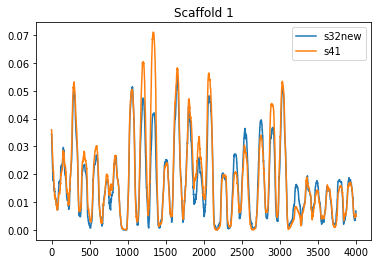

In [8]:
scaffold=1
sart_plot=74000
end_plot=78000
#plot example track
plt.title('Scaffold 1')
for i in data.keys():
    plt.plot(data[i][scaffold][sart_plot:end_plot],label=i)
plt.legend()


In [9]:
#Gaussian convolution
sigma=30
x=np.array(range(-int((sigma*3)),int((1+sigma*3))))
gauss_array=(1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x**2/(2*sigma**2)))
gaussian_convolute_data_sigma3={Sample:{i:np.convolve(data[Sample][i],gauss_array,mode='same') for i in data[Sample].keys()} 
                                for Sample in data.keys()}


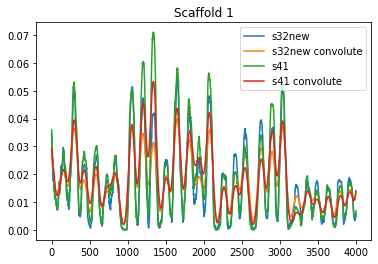

In [10]:
for i in data.keys():
    plt.plot(data[i][scaffold][sart_plot:end_plot],label=i)
    plt.plot(gaussian_convolute_data_sigma3[i][scaffold][sart_plot:end_plot], label=i+' convolute')
plt.title('Scaffold 1')
plt.legend()

In [11]:
# first gaussian derivative convolution
x=np.array(range(-int(sigma*3),int(1+sigma*3)))
gauss_array=(-x/(sigma**3 *np.sqrt(2*np.pi)))*np.exp(-(x**2/(2*sigma**2)))
dgaussian_convolute_data_sigma3={Sample:{i:np.convolve(data[Sample][i],gauss_array,mode='same') for i in data[Sample].keys()} 
                                 for Sample in data.keys()} 


In [12]:
# second gaussian derivative convolution
x=np.array(range(-int(sigma*3),int(1+sigma*3)))
gauss_array=( x**2/sigma**4 - 1/sigma**2 )*(1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x**2/(2*sigma**2)))
d2_gaussian_convolute_data_sigma3={Sample:{i:np.convolve(data[Sample][i],gauss_array,mode='same') for i in data[Sample].keys()} 
                                   for Sample in data.keys()}



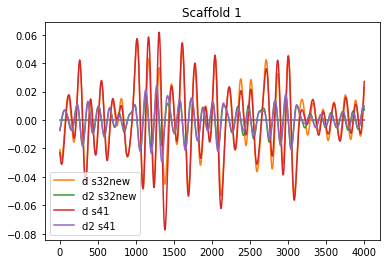

In [13]:
#Plot first and second derivative 
plt.plot(range(abs(sart_plot-end_plot)),[0]*abs(sart_plot-end_plot))
for i in data.keys():
    plt.plot(dgaussian_convolute_data_sigma3[i][scaffold][sart_plot:end_plot]*100, label='d '+i)
    plt.plot(d2_gaussian_convolute_data_sigma3[i][scaffold][sart_plot:end_plot]*1000, label='d2 '+i)
plt.title('Scaffold 1')
plt.legend()

In [14]:
#identify the ranges between inflection points
def identify_flexes(Second_der):
    start=np.nan
    end=np.nan
    flexes=[]
    for i in range(1,len(Second_der)-1):
        if(Second_der[i-1] > 0 and Second_der[i] < 0 ):
            start=i
        elif ( Second_der[i] < 0 and Second_der[i+1] > 0 and not np.isnan(start)):
            end=i+1

        if (not np.isnan(start) and not np.isnan(end)):
            flexes.append(range(start,end))
            start=np.nan
            end=np.nan
    return(flexes)


In [15]:
#run identify_flexes
inflection_ranges={Sample:{scaffold:identify_flexes(d2_gaussian_convolute_data_sigma3[Sample][scaffold]) for scaffold in d2_gaussian_convolute_data_sigma3[Sample].keys()}
                  for Sample in d2_gaussian_convolute_data_sigma3.keys()}


In [16]:
# call peaks as inflection_ranges with a local maxima in it 
def call_peaks(first_der,Ranges):
    Array=[]

    for R in Ranges:
        Ra=np.array(R)
        if any(np.logical_and(first_der[Ra[1:]] < 0 , first_der[Ra[:-1]] > 0)):
            Array.append(R)

    return(Array)

In [17]:
peaks={Sample:{scaffold:call_peaks(first_der=dgaussian_convolute_data_sigma3[Sample][scaffold],Ranges=inflection_ranges[Sample][scaffold]) for scaffold in dgaussian_convolute_data_sigma3[Sample].keys()}
            for Sample in dgaussian_convolute_data_sigma3.keys()}


In [18]:
# create empty tracks
peaks_tracks={Sample:{scaffold:np.zeros(len(data[Sample][scaffold])) for scaffold in data[Sample].keys()} 
              for Sample in data.keys()}


In [19]:
# caculate binary tracks
for Sample in peaks.keys():
    for scaffold in peaks[Sample].keys():
        for RANGE in peaks[Sample][scaffold]:
            peaks_tracks[Sample][scaffold][RANGE]=1


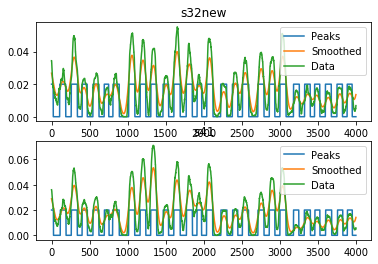

In [20]:
# Plot signals and peaks
scaffold=1
x=range(sart_plot,end_plot)

Keys=[i for i in data.keys()]
fig = plt.figure()
for i in range(2):
    ax1 = fig.add_subplot(2,1,i+1)
    ax1.plot(peaks_tracks[Keys[i]][scaffold][x]/50, label='Peaks')
    ax1.plot(gaussian_convolute_data_sigma3[Keys[i]][scaffold][x],label='Smoothed')
    ax1.plot(data[Keys[i]][scaffold][x],label='Data')
    ax1.set_title(Keys[i])
    ax1.legend()


plt.rcParams['figure.figsize'] = [40, 40]

In [21]:
#merge overlapping ranges if needed

#checks if two ranges are overlapping
def is_overlaping(a, b):
    if (b[0] >= a[0] and b[0] < a[1])  :
        return True
    else:
        return False
 
 
# merge the intervals
def merge(arr):
  #sort the intervals by its first value
    arr=[ [np.min(i),np.max(i)]  for i in arr]
    arr.sort(key = lambda x: x[0])
 
    merged_list= []
    merged_list.append(arr[0])
    for i in range(1, len(arr)):
        pop_element = merged_list.pop()
        if is_overlaping(pop_element, arr[i]):
            new_element = pop_element[0], max(pop_element[1], arr[i][1])
            merged_list.append(new_element)
        else:
            merged_list.append(pop_element)
            merged_list.append(arr[i])
    return [range(x[0],x[1]+1) for x in merged_list]

In [22]:
for Sample in peaks.keys():
    for scaffold in peaks[Sample].keys():
        if peaks[Sample][scaffold]!= []:
            peaks[Sample][scaffold]=merge(peaks[Sample][scaffold])

In [23]:
# select peaks that have less than 10 bp distance
scaffolds_to_use=[i for i in peaks['s32new'].keys() ]
def select_peaks(peaks,key,scaffolds_to_use):
    peak={}
    for i in scaffolds_to_use:
        samples=key.split('_')
        m=peaks[samples[1]][i]
        m=[np.mean(i) for i in m]
        c=peaks[samples[3]][i]
        c=[np.mean(i) for i in c]

        if len(c)!=0 and len(m)!=0:
            sub=abs(np.matrix(c)-np.matrix(m).T)
            peak[i]=(np.array(peaks[samples[3]][i])[np.array(np.min(sub,0) <= 10).flatten()]).tolist()
    return((peak))
peaks['common']=select_peaks(peaks,"distance_s32new_to_s41",scaffolds_to_use)


In [24]:
# drop empty scaffolds
peaks={Sample:{Scaffold:peaks[Sample][Scaffold] for Scaffold in peaks[Sample].keys() if peaks[Sample][Scaffold]!=[]} for Sample in peaks.keys()}


In [25]:
# if there are no peaks on one of Scaffold from one of the two samples use the other one
x=[k for k in peaks['s41'].keys() if k not in peaks['common'].keys()]
for i in x:
    peaks['common'][i]=peaks['s41'][i]
    
x=[k for k in peaks['s32new'].keys() if k not in peaks['common'].keys()]
for i in x:
    peaks['common'][i]=peaks['s32new'][i]

In [26]:
# Save common peaks
for sample in peaks.keys():
    outF = open("/Users/sgnan/Desktop/paramecium/"+sample+"_Nucleosome_peaks.bed", "w")
    for Scaffold in peaks[sample].keys():
        for R in peaks[sample][Scaffold]:  
            outF.write(str(Scaffold)+'\t'+str(np.min(R))+'\t'+str(np.max(R))+"\n")
    outF.close()

In [27]:
# calculate peaks centers
centers={sample:{Scaffold:[np.mean(R) for R in peaks[sample][Scaffold]] for Scaffold in peaks[sample].keys()}
        for sample in peaks.keys()}

#prepare dictionary to allocate distances between peaks
distance={sample:[] for sample in peaks.keys()}

# calculate distances between peaks on a same scaffold
for sample in centers.keys():
    for Scaffold in centers[sample].keys():
            x=np.matrix(centers[sample][Scaffold])
            x=np.abs(x-x.T)
            np.fill_diagonal(x,10**10)
            if len(x)!=0:
                distance[sample].append( np.triu(x,1).flatten())

# concatenate distances between different scaffolds in one array                
for sample in distance.keys():
    distance[sample]=np.concatenate(distance[sample]).flatten()


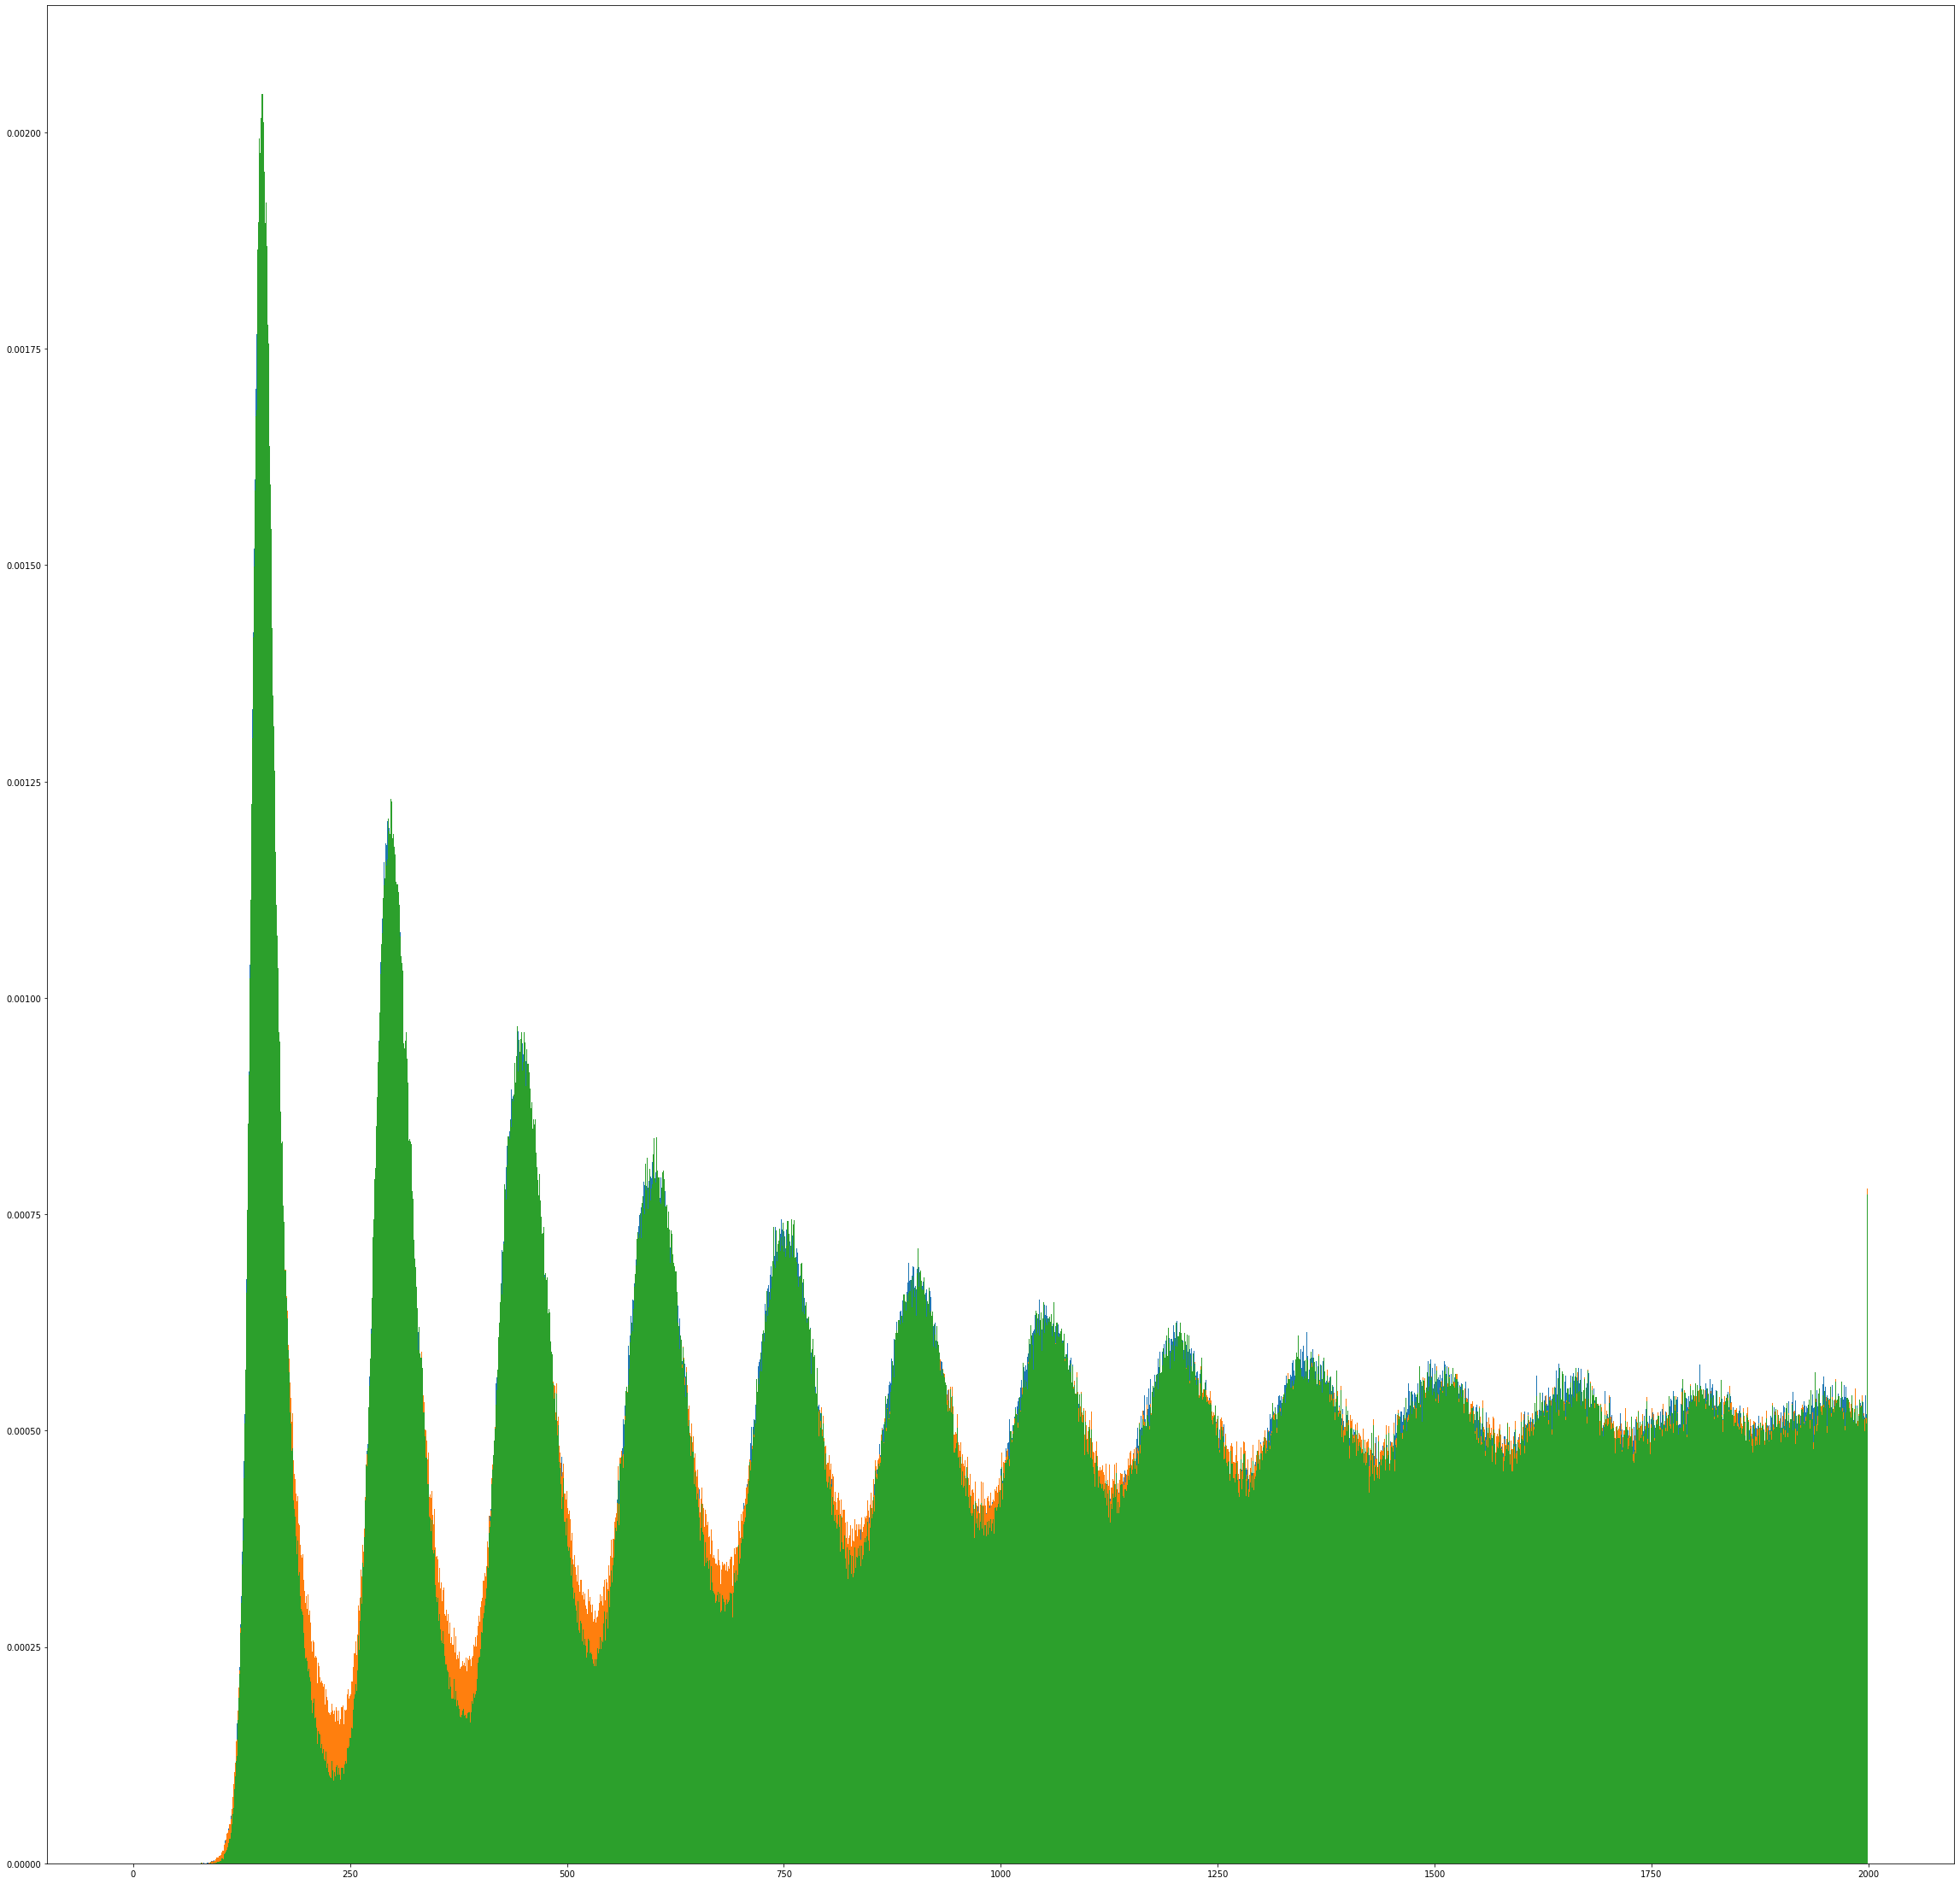

In [28]:
#use hist to get the density distribution of the peak to peak distances within 2kb
Max=2000
p={sample:plt.hist(distance[sample],bins=range(1,Max),density=True) for sample in centers.keys()}

In [29]:
# smooth and id local maxima
def smooth_and_maxima(p,sigma=10):
    #Gaussian convolution
    x=np.array(range(-int((sigma*3)),int((1+sigma*3))))
    gauss_array=(1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x**2/(2*sigma**2)))
    Smooth=np.convolve(p[0],gauss_array,mode='same') 
    # deriv
    x=np.array(range(-int(sigma*3),int(1+sigma*3)))
    gauss_array=(-x/(sigma**3 *np.sqrt(2*np.pi)))*np.exp(-(x**2/(2*sigma**2)))
    der=np.convolve(p[0],gauss_array,mode='same') 
    #maxima
    maxima=np.where(np.logical_and(der[1:] < 0 , der[:-1] > 0))[0]
    maxima=maxima[:-1]
    return {'Data':p[0],'Smooth':Smooth,'Maxima':maxima}

p={sample:smooth_and_maxima(p[sample]) for sample in centers.keys()}

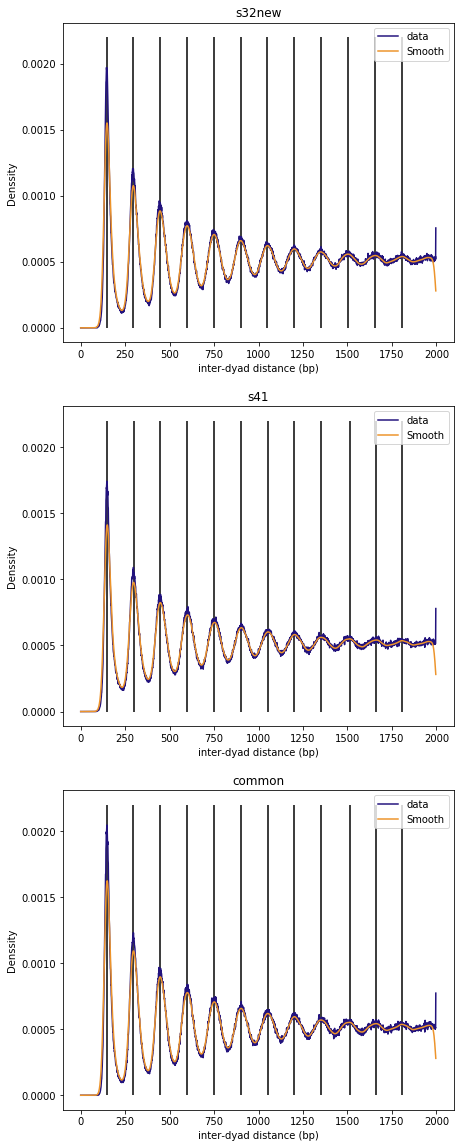

In [30]:
#compare fit and real data
Samples=[*p.keys()]
fig, axs = plt.subplots(3, figsize=(7, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for h in range(3):
    axs[h].plot(p[Samples[h]]['Data'], label='data', color="#22127d")
    axs[h].plot(p[Samples[h]]['Smooth'], label='Smooth', color="#ed942b")
    axs[h].vlines(p[Samples[h]]['Maxima'],0,0.0022)
    axs[h].set_title(Samples[h])
    axs[h].legend()
    axs[h].set_xlabel('inter-dyad distance (bp)')
    axs[h].set_ylabel('Denssity')

plt.savefig('NRL.pdf',  format='pdf')


In [31]:
# using the first n peaks calculate liner regression between distance and peak position (NRL)
def Calc_NRL(maxima,how_many=8):
    x=np.array(range(1,how_many+1))
    y=np.array(maxima[:how_many])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[:-1],y[:-1])
    result='{}±{}'.format(np.round(slope,2),np.round(np.sqrt(len(x))*std_err,2))
    if(np.sign(intercept)==-1):
        sign='-'
    else:
        sign='+'
    
    funtion='y={}x{}{}'.format(np.round(slope,2),sign,abs(np.round(intercept,2)))
    return {'Maxima':y,
            'Slope':slope,
            'Intercept':intercept,
            'R2':r_value**2,
            'p_value':p_value,
            'std_err':std_err,
            'Result':result,
            'Function':funtion}
    
fit={sample:Calc_NRL(p[sample]['Maxima'],how_many=8) for sample in centers.keys()}

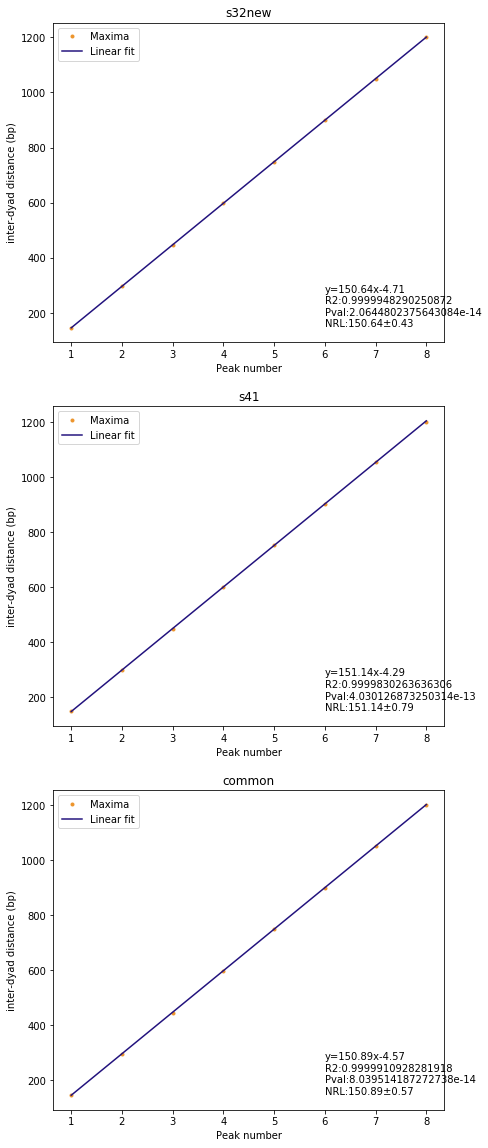

In [32]:
#plot data and fitting info
Samples=[*p.keys()]
fig, axs = plt.subplots(3, figsize=(7, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for h in range(3):
    x=range(1,len(fit[Samples[h]]['Maxima'])+1)
    fit_data=fit[Samples[h]]['Slope']*x+fit[Samples[h]]['Intercept']
    
    
    axs[h].plot(x,fit[Samples[h]]['Maxima'],'.', label='Maxima',color="#ed942b")
    axs[h].plot(x,fit_data, label='Linear fit', color="#22127d")
    axs[h].text(6,150,fit[Samples[h]]['Function']+'\nR2:'+str(fit[Samples[h]]['R2'])+'\nPval:'+str(fit[Samples[h]]['p_value'])+'\nNRL:'+fit[Samples[h]]['Result'])
    axs[h].set_title(Samples[h])
    axs[h].legend()
    axs[h].set_xlabel('Peak number')
    axs[h].set_ylabel('inter-dyad distance (bp)')

    
plt.savefig('NRL_fit.pdf',  format='pdf')
